In [ ]:
# Install library tambahan jika diperlukan
!pip install scikit-learn pandas matplotlib numpy dask

# Import library
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Upload file CSV
from google.colab import files
uploaded = files.upload()

Saving exported_columns_sungaibatanghari2.csv to exported_columns_sungaibatanghari2.csv


In [ ]:
# Membaca data dari file CSV menggunakan Dask
file_name = list(uploaded.keys())[0]
data = dd.read_csv(file_name)

In [ ]:
# Target kolom yang akan digunakan
target_columns = ['TSS', 'pH', 'EC', 'TDS', 'CHLA']
data = data[target_columns]

# Mengetahui jumlah nilai null per kolom
null_counts = data.isna().sum().compute()
print("Jumlah nilai null awal pada setiap kolom:")
print(null_counts)
print("-" * 50)

# Mengisi nilai NaN dengan median (menggunakan Dask)
data = data.fillna(data.median().compute())

# Memastikan tidak ada nilai null setelah pengisian
null_counts_after = data.isna().sum().compute()
print("Jumlah nilai null setelah pengisian:")
print(null_counts_after)
print("-" * 50)

# Mengonversi ke Pandas untuk kompatibilitas dengan Scikit-learn
data = data.compute()

# Standarisasi data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# PCA untuk menurunkan dimensi menjadi 2 komponen
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
data[['PCA1', 'PCA2']] = pca_result  # Menyimpan kedua komponen

Jumlah nilai null awal pada setiap kolom:
TSS     0
pH      0
EC      0
TDS     0
CHLA    0
dtype: int64
--------------------------------------------------
Jumlah nilai null setelah pengisian:
TSS     0
pH      0
EC      0
TDS     0
CHLA    0
dtype: int64
--------------------------------------------------


In [ ]:
data[['PCA1', 'PCA2']].reset_index(drop=True).head(50)

,PCA1,PCA2
0,2.780560,0.033879
1,2.606912,0.025016
2,2.661499,-0.077303
3,2.693052,-0.125845
4,2.655673,0.009672
5,2.822388,0.084154
6,2.905257,0.109910
7,2.560045,0.016853
8,2.537776,0.301520
9,2.673181,0.283965


In [ ]:
scaled_df = pd.DataFrame(scaled_data, columns=target_columns)
print(scaled_df.head())

        TSS        pH        EC       TDS      CHLA
0  1.302730  1.178749  1.135895  1.135895  1.480686
1  1.247834  1.173202  0.984176  0.984176  1.461568
2  1.185812  1.233186  1.004552  1.004552  1.539758
3  1.176702  1.241771  0.998502  0.998502  1.623298
4  1.226417  1.134394  1.081871  1.081871  1.428469


**EVALUASI HASIL KLASTERING**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import pairwise_distances
import numpy as np

In [ ]:
# Fungsi untuk menghitung Gap Statistic
def gap_statistic(X, n_refs=5, max_clusters=5):
    from sklearn.cluster import KMeans
    import numpy as np

    gaps = []
    for k in range(1, max_clusters + 1):
        ref_disps = []
        for _ in range(n_refs):
            random_reference = np.random.uniform(X.min(axis=0), X.max(axis=0), size=X.shape)
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            km.fit(random_reference)
            ref_disps.append(km.inertia_)

        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X)
        orig_disp = km.inertia_

        gap = np.log(np.mean(ref_disps)) - np.log(orig_disp)
        gaps.append(gap)

    return gaps

# Hitung Gap Statistic
gaps = gap_statistic(data[['PCA1', 'PCA2']].values, n_refs=5, max_clusters=5)

# Evaluasi KMeans dengan berbagai metrik
for n_clusters in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    data['Cluster'] = kmeans.fit_predict(data[['PCA1', 'PCA2']])

    silhouette_avg = silhouette_score(data[['PCA1', 'PCA2']], data['Cluster'])
    dbi = davies_bouldin_score(data[['PCA1', 'PCA2']], data['Cluster'])
    calinski_harabasz = calinski_harabasz_score(data[['PCA1', 'PCA2']], data['Cluster'])
    wss = kmeans.inertia_
    gap = gaps[n_clusters-1]

    print(f"Evaluasi untuk {n_clusters} Klaster:")
    print(f"  Davies-Bouldin Index: {dbi:.5f}")
    print(f"  Silhouette Score: {silhouette_avg:.5f}")
    print(f"  Calinski-Harabasz Index: {calinski_harabasz:.5f}")
    print(f"  Within-Cluster Sum of Squares (WSS / Cohesion): {wss:.5f}")
    print(f"  Gap Statistic: {gap:.5f}")
    print("-" * 50)


Evaluasi untuk 2 Klaster:
  Davies-Bouldin Index: 0.56538
  Silhouette Score: 0.59496
  Calinski-Harabasz Index: 310467.53062
  Within-Cluster Sum of Squares (WSS / Cohesion): 183655.74426
  Gap Statistic: 1.31186
--------------------------------------------------
Evaluasi untuk 3 Klaster:
  Davies-Bouldin Index: 0.64589
  Silhouette Score: 0.50656
  Calinski-Harabasz Index: 335128.93471
  Within-Cluster Sum of Squares (WSS / Cohesion): 101062.56178
  Gap Statistic: 1.63573
--------------------------------------------------
Evaluasi untuk 4 Klaster:
  Davies-Bouldin Index: 0.69395
  Silhouette Score: 0.45727
  Calinski-Harabasz Index: 349720.43280
  Within-Cluster Sum of Squares (WSS / Cohesion): 68580.38466
  Gap Statistic: 1.73694
--------------------------------------------------
Evaluasi untuk 5 Klaster:
  Davies-Bouldin Index: 0.73603
  Silhouette Score: 0.42766
  Calinski-Harabasz Index: 357349.90273
  Within-Cluster Sum of Squares (WSS / Cohesion): 51854.52979
  Gap Statistic: 1

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd


for n_clusters in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['Cluster'] = kmeans.fit_predict(data[['PCA1', 'PCA2']])

    # Menampilkan jumlah data dalam setiap klaster
    cluster_counts = data['Cluster'].value_counts().sort_index()
    print(f"\nJumlah data per klaster untuk {n_clusters} Klaster:")
    for cluster, count in cluster_counts.items():
        print(f"  Cluster {cluster + 1}: {count}")

    print("-" * 50)



Jumlah data per klaster untuk 2 Klaster:
  Cluster 1: 81158
  Cluster 2: 48604
--------------------------------------------------

Jumlah data per klaster untuk 3 Klaster:
  Cluster 1: 56651
  Cluster 2: 41323
  Cluster 3: 31788
--------------------------------------------------

Jumlah data per klaster untuk 4 Klaster:
  Cluster 1: 42297
  Cluster 2: 27046
  Cluster 3: 21013
  Cluster 4: 39406
--------------------------------------------------

Jumlah data per klaster untuk 5 Klaster:
  Cluster 1: 30109
  Cluster 2: 25630
  Cluster 3: 17173
  Cluster 4: 35772
  Cluster 5: 21078
--------------------------------------------------


In [ ]:
# Melihat eigenvalues dan eigenvectors
eigenvectors = pca.components_

# Explained variance ratio dan eigenvalues
explained_variance_ratio = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

print("Explained Variance Ratio (Proporsi Variansi yang Dijelaskan) untuk Setiap Komponen:")
print(explained_variance_ratio)

print("\nEigenvalues (Nilai Eigen):")
print(eigenvalues)

print("\nEigenvectors:")
print(eigenvectors)

Explained Variance Ratio (Proporsi Variansi yang Dijelaskan) untuk Setiap Komponen:
[0.90592773 0.0544084 ]

Eigenvalues (Nilai Eigen):
[4.52967355 0.27204411]

Eigenvectors:
[[ 0.41858534  0.45188416  0.46033541  0.46033541  0.44358724]
 [ 0.85382178 -0.12335586 -0.09221854 -0.09221854 -0.48863399]]


In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[['PCA1', 'PCA2']])

# Gabungkan hasil klaster dengan data asli
cluster_summary = data.groupby('Cluster')[['TSS', 'pH', 'EC', 'TDS', 'CHLA']].mean()
print(cluster_summary)

                  TSS        pH           EC          TDS      CHLA
Cluster                                                            
0        16558.574872  8.702691  7767.689900  3883.844944  8.905938
1        13362.163633  8.638113  4617.165114  2308.582556  2.997477
2         4771.180141  8.539013  1213.189189   606.594595  0.118296
3        14913.391651  8.679349  6160.270300  3080.135147  6.059148
4        10490.621902  8.581960  2732.502736  1366.251368  0.861920


Hasil label klaster KMeans:
[0 0 0 ... 0 0 0]
Rata-rata tiap variabel setelah standarisasi per klaster:
              TSS        pH        EC       TDS      CHLA
Cluster                                                  
0        0.878114  1.008168  1.201328  1.201328  1.316806
1       -0.575986 -1.003432 -0.980013 -0.980013 -1.069165
2        0.489319  0.637281  0.500590  0.500590  0.492857
3        0.101924 -0.056078 -0.155170 -0.155170 -0.430073
4       -1.956535 -1.720782 -1.638230 -1.638230 -1.289200


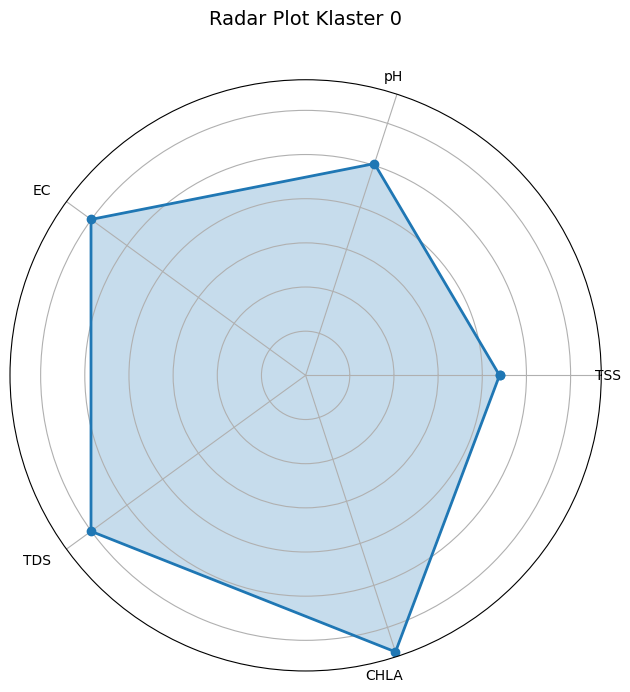

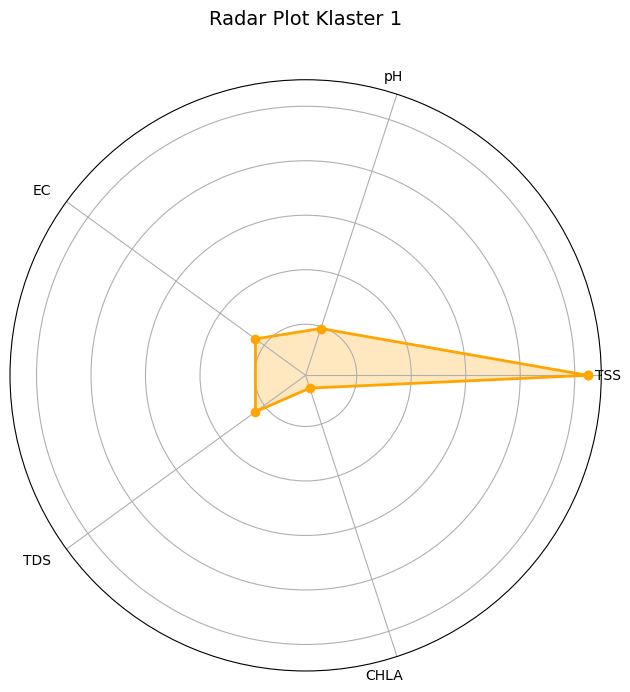

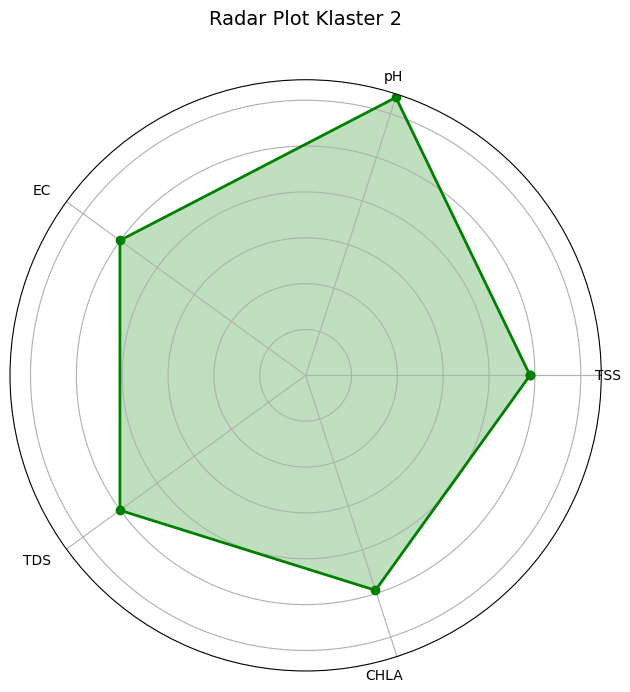

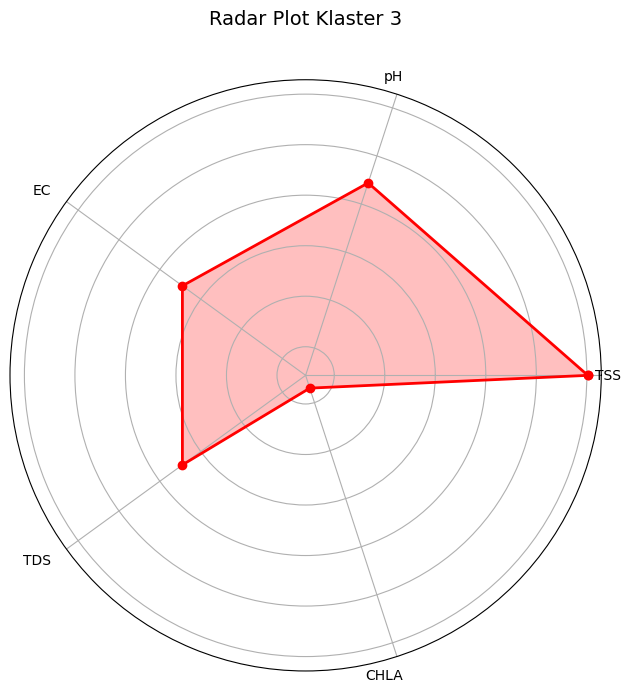

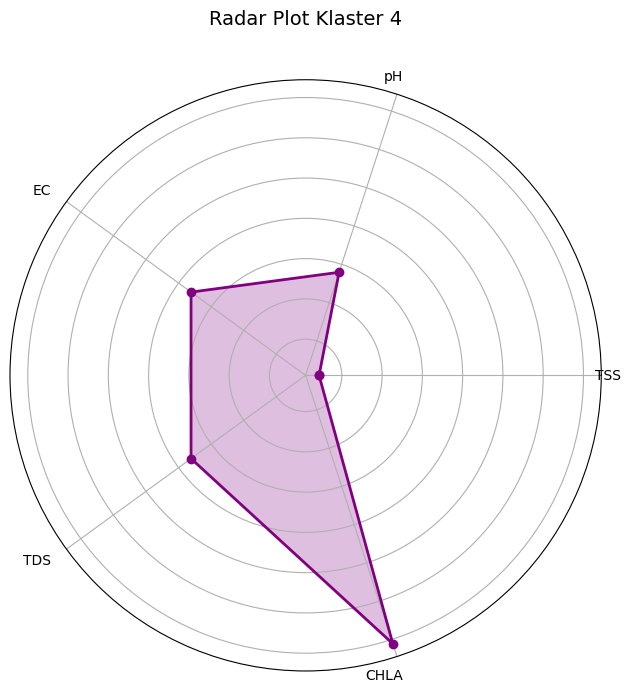

In [ ]:
# Step 2: Klasterisasi menggunakan KMeans dengan 5 klaster
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(scaled_data)
data['Cluster'] = kmeans.labels_

# Cek hasil label klaster
print("Hasil label klaster KMeans:")
print(kmeans.labels_)

# Step 3: Hitung rata-rata tiap variabel per klaster
cluster_means = pd.DataFrame(scaled_data, columns=target_columns)
cluster_means['Cluster'] = kmeans.labels_
cluster_means = cluster_means.groupby('Cluster').mean()

print("Rata-rata tiap variabel setelah standarisasi per klaster:")
print(cluster_means)

# Step 4: Membuat radar plot per klaster
def create_spider_plot_per_cluster(cluster_means):
    labels = cluster_means.columns.tolist()
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    # Warna untuk 5 klaster, urut sesuai label 0,1,2,3,4
    colors = ['#1f77b4', 'orange', 'green', 'red', 'purple']

    for cluster in sorted(cluster_means.index):  # urutkan label klaster
        values = cluster_means.loc[cluster].values.flatten().tolist()
        values += values[:1]

        fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
        ax.plot(angles, values, marker='o', linewidth=2, color=colors[cluster])
        ax.fill(angles, values, alpha=0.25, color=colors[cluster])

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels, fontsize=10, rotation=30, ha="right")

        ax.set_title(f'Radar Plot Klaster {cluster}', size=14, y=1.08)
        ax.set_yticklabels([])
        plt.tight_layout()
        plt.show()

# Panggil fungsi untuk buat radar per klaster
create_spider_plot_per_cluster(cluster_means)


[0 0 0 ... 0 0 0]
Rata-rata tiap variabel setelah standarisasi per klaster:
              TSS        pH        EC       TDS      CHLA
Cluster                                                  
0        0.878114  1.008168  1.201328  1.201328  1.316806
1       -0.575986 -1.003432 -0.980013 -0.980013 -1.069165
2        0.489319  0.637281  0.500590  0.500590  0.492857
3        0.101924 -0.056078 -0.155170 -0.155170 -0.430073
4       -1.956535 -1.720782 -1.638230 -1.638230 -1.289200


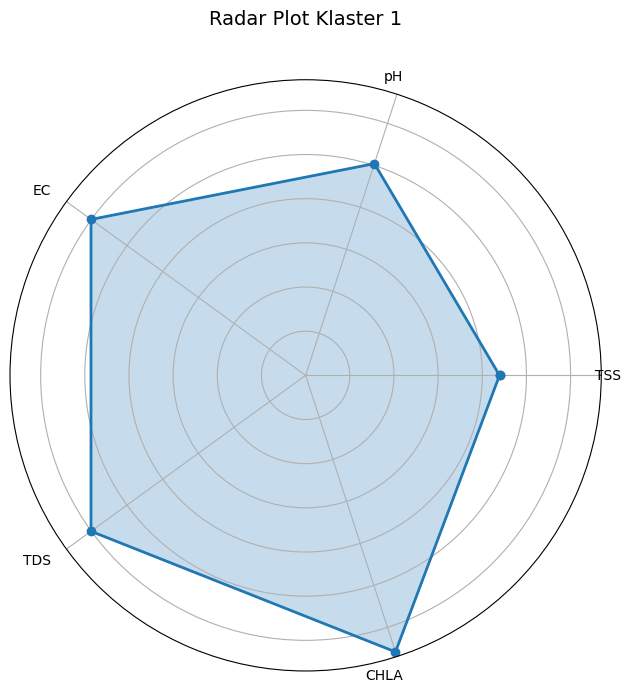

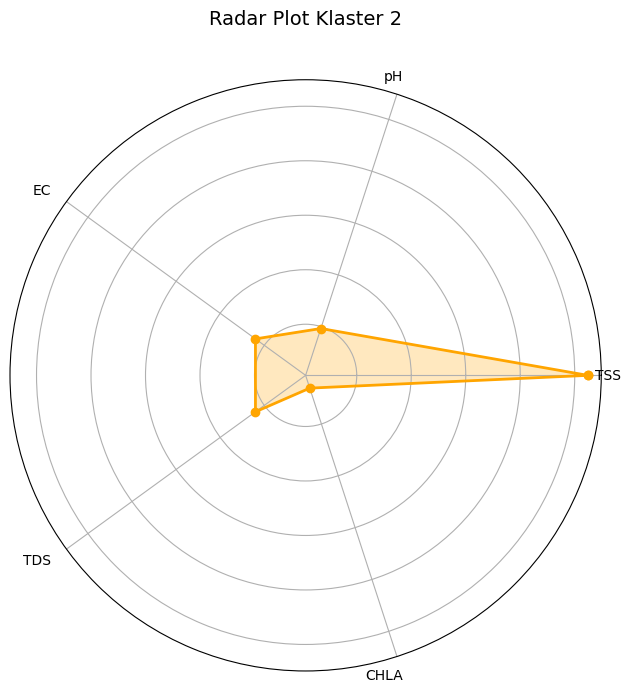

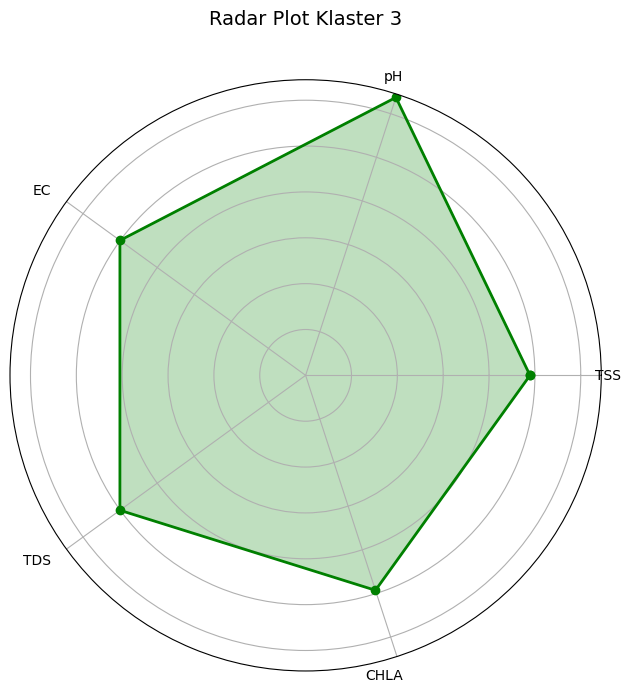

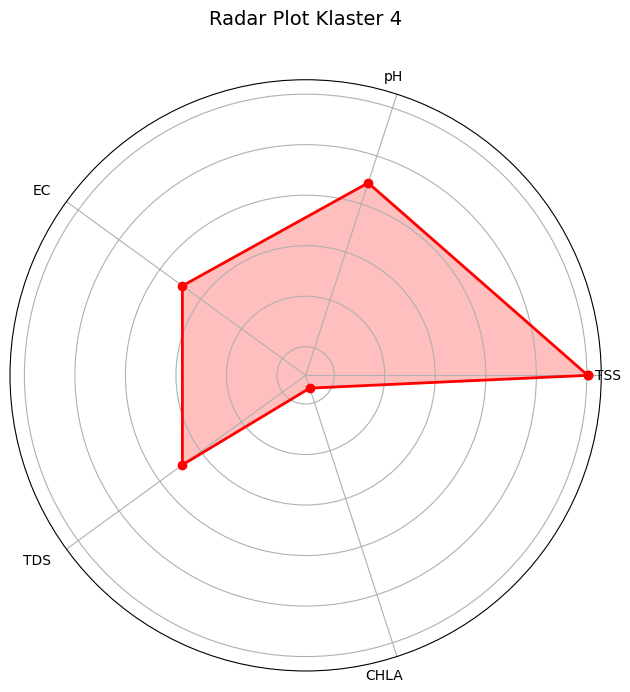

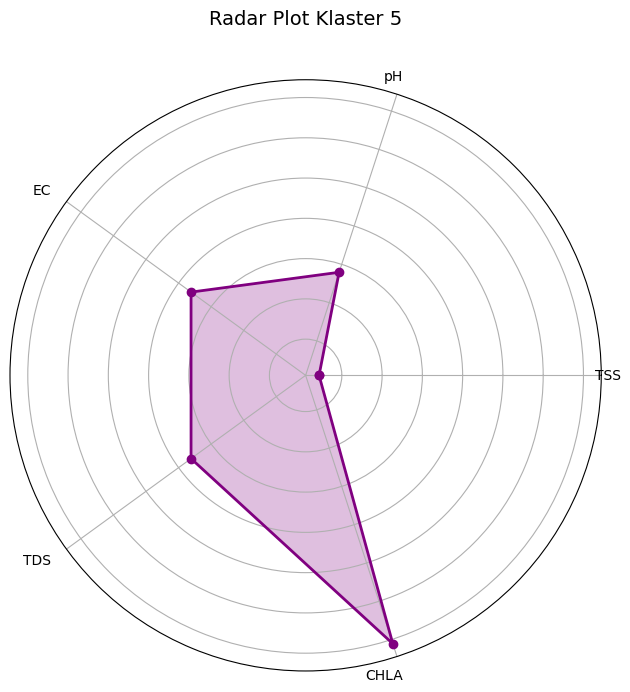

In [ ]:
# Step 2: Klasterisasi menggunakan KMeans dengan 5 klaster
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(scaled_data)
data['Cluster'] = kmeans.labels_

# Step 3: Hitung rata-rata tiap variabel per klaster
cluster_means = pd.DataFrame(scaled_data, columns=target_columns)
cluster_means['Cluster'] = kmeans.labels_
cluster_means = cluster_means.groupby('Cluster').mean()

print(kmeans.labels_)

print("Rata-rata tiap variabel setelah standarisasi per klaster:")
print(cluster_means)

# Step 4: Membuat radar plot per klaster
def create_spider_plot_per_cluster(cluster_means):
    labels = cluster_means.columns.tolist()
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    # Warna untuk 5 klaster
    colors = ['#1f77b4', 'orange', 'green', 'red', 'purple']

    for cluster in cluster_means.index:
        values = cluster_means.loc[cluster].values.flatten().tolist()
        values += values[:1]

        fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
        ax.plot(angles, values, marker='o', linewidth=2, color=colors[cluster])
        ax.fill(angles, values, alpha=0.25, color=colors[cluster])

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels, fontsize=10, rotation=30, ha="right")

        ax.set_title(f'Radar Plot Klaster {cluster+1}', size=14, y=1.08)
        ax.set_yticklabels([])
        plt.tight_layout()
        plt.show()

# Panggil fungsi untuk buat radar per klaster
create_spider_plot_per_cluster(cluster_means)


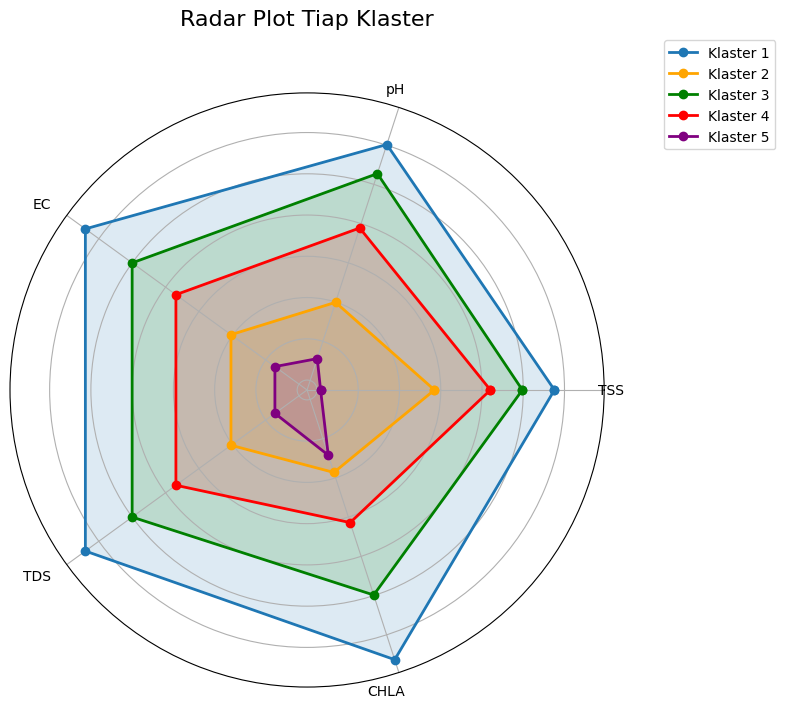

In [ ]:
def create_combined_spider_plot(cluster_means):
    labels = cluster_means.columns.tolist()
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    # Warna untuk 5 klaster
    colors = ['#1f77b4', 'orange', 'green', 'red', 'purple']

    # Buat figure tunggal
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for cluster in cluster_means.index:
        values = cluster_means.loc[cluster].values.flatten().tolist()
        values += values[:1]

        ax.plot(angles, values, marker='o', linewidth=2, label=f'Klaster {cluster+1}', color=colors[cluster])
        ax.fill(angles, values, alpha=0.15, color=colors[cluster])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10, rotation=30, ha="right")

    ax.set_title('Radar Plot Tiap Klaster', size=16, y=1.1)
    ax.set_yticklabels([])

    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

# Panggil fungsi
create_combined_spider_plot(cluster_means)


**DOWNLOAD FILE**

In [ ]:
# Menambahkan kolom 'Cluster_X' untuk setiap jumlah klaster
for n_clusters in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data[f'Cluster_{n_clusters}'] = kmeans.fit_predict(data[['PCA1', 'PCA2']])

# Mengekspor data ke file Excel
output_file = 'hasil_klasterisasi_kmeans_pca_revisi1_1.xlsx'
data.to_excel(output_file, index=False)

print(f"File hasil klasterisasi telah disimpan di {output_file}")

# Menyediakan file untuk di-download
files.download(output_file)

File hasil klasterisasi telah disimpan di hasil_klasterisasi_kmeans_pca_revisi1_1.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>